## Pré-processamento dos dados

---

**Objetivo geral:** prever o preço de venda de imóveis residenciais com base em dados históricos. 


**Fonte dos dados:** https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

**Outras fontes citadas**: ver seção "Referêrencias" na documentação do projeto.

**Passos desenvolvidos nesse notebook:**
* Exploração da estrutura dos dados
* Tratamento de valores nulos e faltantes
* Detecção de outliers
* Label Encoder: transformação das variáveis categóricas
* Seleção de atributos
* Escalonamento dos dados
* Inspeção de auto-correlação entre variáveis
* Exportação dos dados no formato .pkl

---

#### Primeira etapa, importação das bibliotecas e ingestão dos dados:

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyod.models.knn import KNN
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
import warnings

In [2]:
# Configurações e variáveis globais
warnings.filterwarnings("ignore")
target = "SalePrice"
non_numeric_dtypes = "object"
numeric_dtypes = ["int64", "float64"]
thresold_relative_importance = 0.010
thresold_high_correlation = 0.95
thresold_missing_values = 0.15

In [3]:
# Ingestão dos dados
path_file = "../data/train.csv"
house = pd.read_csv(path_file)
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


---

#### Declarando funções para reaproveitamento de trechos de código usados em diferentes partes da análise:

In [4]:
def print_dataset_shape(df):
    print(f'This dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

In [5]:
def show_missing_cols(data):
    any_missing_cols = [col for col in data.columns if data[col].isnull().any()]
    tot_missing_col = data[any_missing_cols].isnull().sum()
    return tot_missing_col

---

#### Explorando a estrutura  dos dados:

In [6]:
print_dataset_shape(house)

This dataset contains 1460 rows and 81 columns.


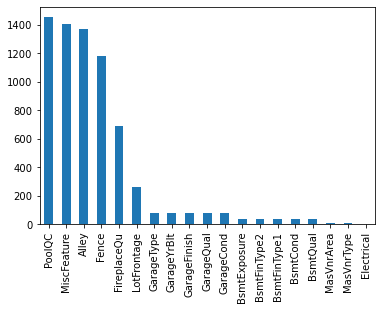

In [7]:
missing = show_missing_cols(house)
missing.sort_values(ascending=False, inplace=True)
missing.plot.bar();

In [8]:
house.duplicated().sum()

0

---

#### Limpeza e transformação dos dados

Aqui tomei a decisão  de eliminar as colunas que possuem > 15% de dados nulos ou ausentes. Em alguns casos a imputação de valores pode ser interessante, ao invés da exclusão de colunas, pois podemos perder atributos importantes. Porém, considero que 15% de dados faltantes em um atributo seja um limite razoável, e que mais valores do que isso também pode comprometer a confiabilidade das inferêrencias estatísticas durante a construção dos modelos. Não existe um consenso sobre a proporção de dados faltantes que é aceitável em uma análise, mas alguns autores argumentam que mais de 10% já pode causar algum impacto (fonte: 1). Por isso optei pelo valor de 0.15 (armazenado na variável "thresold_missing_values").

In [9]:
total_values = len(house)
min_missing_values_todrop = total_values*thresold_missing_values
print(f' Drop columns with >= {round(min_missing_values_todrop)} missing values')

 Drop columns with >= 219 missing values


In [10]:
cols_to_drop = [col for col in house.columns if house[col].isnull().sum() >= min_missing_values_todrop ]
cols_to_drop

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [11]:
house.drop(cols_to_drop, axis=1, inplace=True)
print_dataset_shape(house)

This dataset contains 1460 rows and 75 columns.


Checando quais colunas ainda tem valores faltantes (colunas com < thresold_missing_values):

In [12]:
show_missing_cols(house)

MasVnrType       8
MasVnrArea       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64

Se eu apagasse todas as linhas únicas com pelo menos um registro faltante, quantas linhas eu perderia?

In [13]:
print(f'{house.isnull().any(axis=0).sum()} rows with any missig value.')

13 rows with any missig value.


Considero que seja um número pequeno de linhas e que posso excluí-las da base sem causar grandes impactos:

In [14]:
house.dropna(inplace=True)
show_missing_cols(house)

Series([], dtype: float64)

In [15]:
print_dataset_shape(house)

This dataset contains 1338 rows and 75 columns.


--- 
Identificando variáveis numéricas e categóricas na base de dados:etapa importante para quando estivermos transformando as variáveis categóricas em numéricas

In [16]:
non_numeric_cols = house.select_dtypes(include = [non_numeric_dtypes]).columns
numeric_cols = house.select_dtypes(include = numeric_dtypes).columns
(len(numeric_cols) + len(non_numeric_cols)) == len(house.columns)

True

---
Detecção de outliers: aqui utilizei o módulo KNN Detector da biblioteca PyOD, construída para ajudar na detecção de outliers em dados multivariados, como no meu caso (fontes 2 e 3 das referências). O algoritmo funciona como um classificador baseado em distância, similar ao famoso KNNeighbors da biblioteca SciKitLearn. 

Durante a análise ele irá computar a distância entre todos os pontos e rotular como outlier (classe 1) aqueles que possuem valores muito discrepantes em relação aos seus k vizinhos mais próximos. O valor de corte para a detecção pode ser ajustado através do parâmetro "contamination", que representa a proporção máxima de outliers a serem detectados em relação ao tamanho total do conjunto de dados (default = 10%).

In [17]:
detector = KNN()
detector.fit(house.loc[:, numeric_cols])
outliers_predict = detector.labels_

In [18]:
outliers_index = [index for index in range(len(outliers_predict)) if outliers_predict[index] == 1]
print(f'There are {len(outliers_index)} outliers')

There are 134 outliers


Excluindo os valores discrepantes:

In [19]:
outliers_list = house.iloc[outliers_index,:]
house.drop(house.index[outliers_index], inplace=True)

In [20]:
print_dataset_shape(house)

This dataset contains 1204 rows and 75 columns.


In [21]:
# Identificação de linhas excluídas
outliers_list

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
11,12,60,RL,11924,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2006,New,Partial,345000
29,30,30,RM,6324,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,87,0,0,0,0,5,2008,WD,Normal,68500
30,31,70,C (all),8500,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,172,0,0,0,0,7,2008,WD,Normal,40000
53,54,20,RL,50271,Pave,IR1,Low,AllPub,Inside,Gtl,...,0,0,0,0,0,11,2006,WD,Normal,385000
58,59,60,RL,13682,Pave,IR2,HLS,AllPub,CulDSac,Gtl,...,37,0,0,0,0,10,2006,New,Partial,438780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,1424,80,RL,19690,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,738,0,8,2006,WD,Alloca,274970
1430,1431,60,RL,21930,Pave,IR3,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2006,WD,Normal,192140
1432,1433,30,RL,10800,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,64500
1437,1438,20,RL,12444,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,304,0,0,0,11,2008,New,Partial,394617


---
Separando o dataset nas bases de variáveis preditoras (X) e variável target y:

In [22]:
X_houses = house.drop([target, "Id"], axis=1)
y_houses = house[target]

Processamento das variáveis não numéricas: label encoder

In [23]:
for col in non_numeric_cols:
    X_houses[col] = X_houses[col].astype('category').cat.codes
    
X_houses.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,8450,1,3,3,0,4,0,5,...,61,0,0,0,0,0,2,2008,8,4
1,20,3,9600,1,3,3,0,2,0,24,...,0,0,0,0,0,0,5,2007,8,4
2,60,3,11250,1,0,3,0,4,0,5,...,42,0,0,0,0,0,9,2008,8,4
3,70,3,9550,1,0,3,0,0,0,6,...,35,272,0,0,0,0,2,2006,8,0
4,60,3,14260,1,0,3,0,2,0,15,...,84,0,0,0,0,0,12,2008,8,4


In [24]:
print(f'There are {len(X_houses.select_dtypes(include = [non_numeric_dtypes]).columns)} non-numerical variables.')

There are 0 non-numerical variables.


---
Checando correlação entre as variáveis: <br>
Para pares de variáveis com alta correlação (> 0.95), uma delas será apagada:

In [25]:
matrix_corr = X_houses.corr().abs().unstack().sort_values(ascending=False)
highest_corr_attributes = matrix_corr[(matrix_corr.values > thresold_high_correlation) & (matrix_corr.values != 1)]
cols_to_drop = [cols[0] for i,cols in enumerate(highest_corr_attributes.index) if i % 2 == 0]
X_houses.drop(cols_to_drop, axis=1, inplace=True)

In [26]:
print(f'Number of columns highly correlated and dropped: {len(cols_to_drop)}.')
print_dataset_shape(X_houses)

Number of columns highly correlated and dropped: 0.
This dataset contains 1204 rows and 73 columns.


---
Escalonamento dos dados:


Usei o método da normalização, que considera os valores máximo e mínimo de cada atributo previsor. A expressão matemática da normalização pode ser encontrada aqui: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html. Porém, também fiz experimentações com o método de padronização e não obtive mudanças significativas nos resultados das análises.

In [27]:
scaler = MinMaxScaler()
X_houses_scaler = scaler.fit_transform(X_houses.values)

---

#### Seleção de atributos

Método TreeCliassifier: o primeiro passo foi treinar o algoritmo classificador com a base de dados para que ele possa aprender sobre eles, e então utilizar o atributo _feature importances_ do objeto classificador para conhecer a importância relativa de cada uma das variáveis previsoras:

In [28]:
tree_clf = ExtraTreesClassifier()
tree_clf.fit(X_houses_scaler, y_houses)
features = tree_clf.feature_importances_

In [29]:
data = {"Feature_name": X_houses.columns, "Relative_importance": features*100}
feat_importance_df = pd.DataFrame(data).sort_values(by="Relative_importance", ascending=False)

In [30]:
feat_importance_df

,Feature_name,Relative_importance
2,LotArea,3.178620
34,BsmtUnfSF,3.124530
43,GrLivArea,3.123533
69,MoSold,3.117261
40,1stFlrSF,3.080935
...,...,...
19,RoofMatl,0.073004
11,Condition2,0.040717
67,PoolArea,0.016416
6,Utilities,0.006155


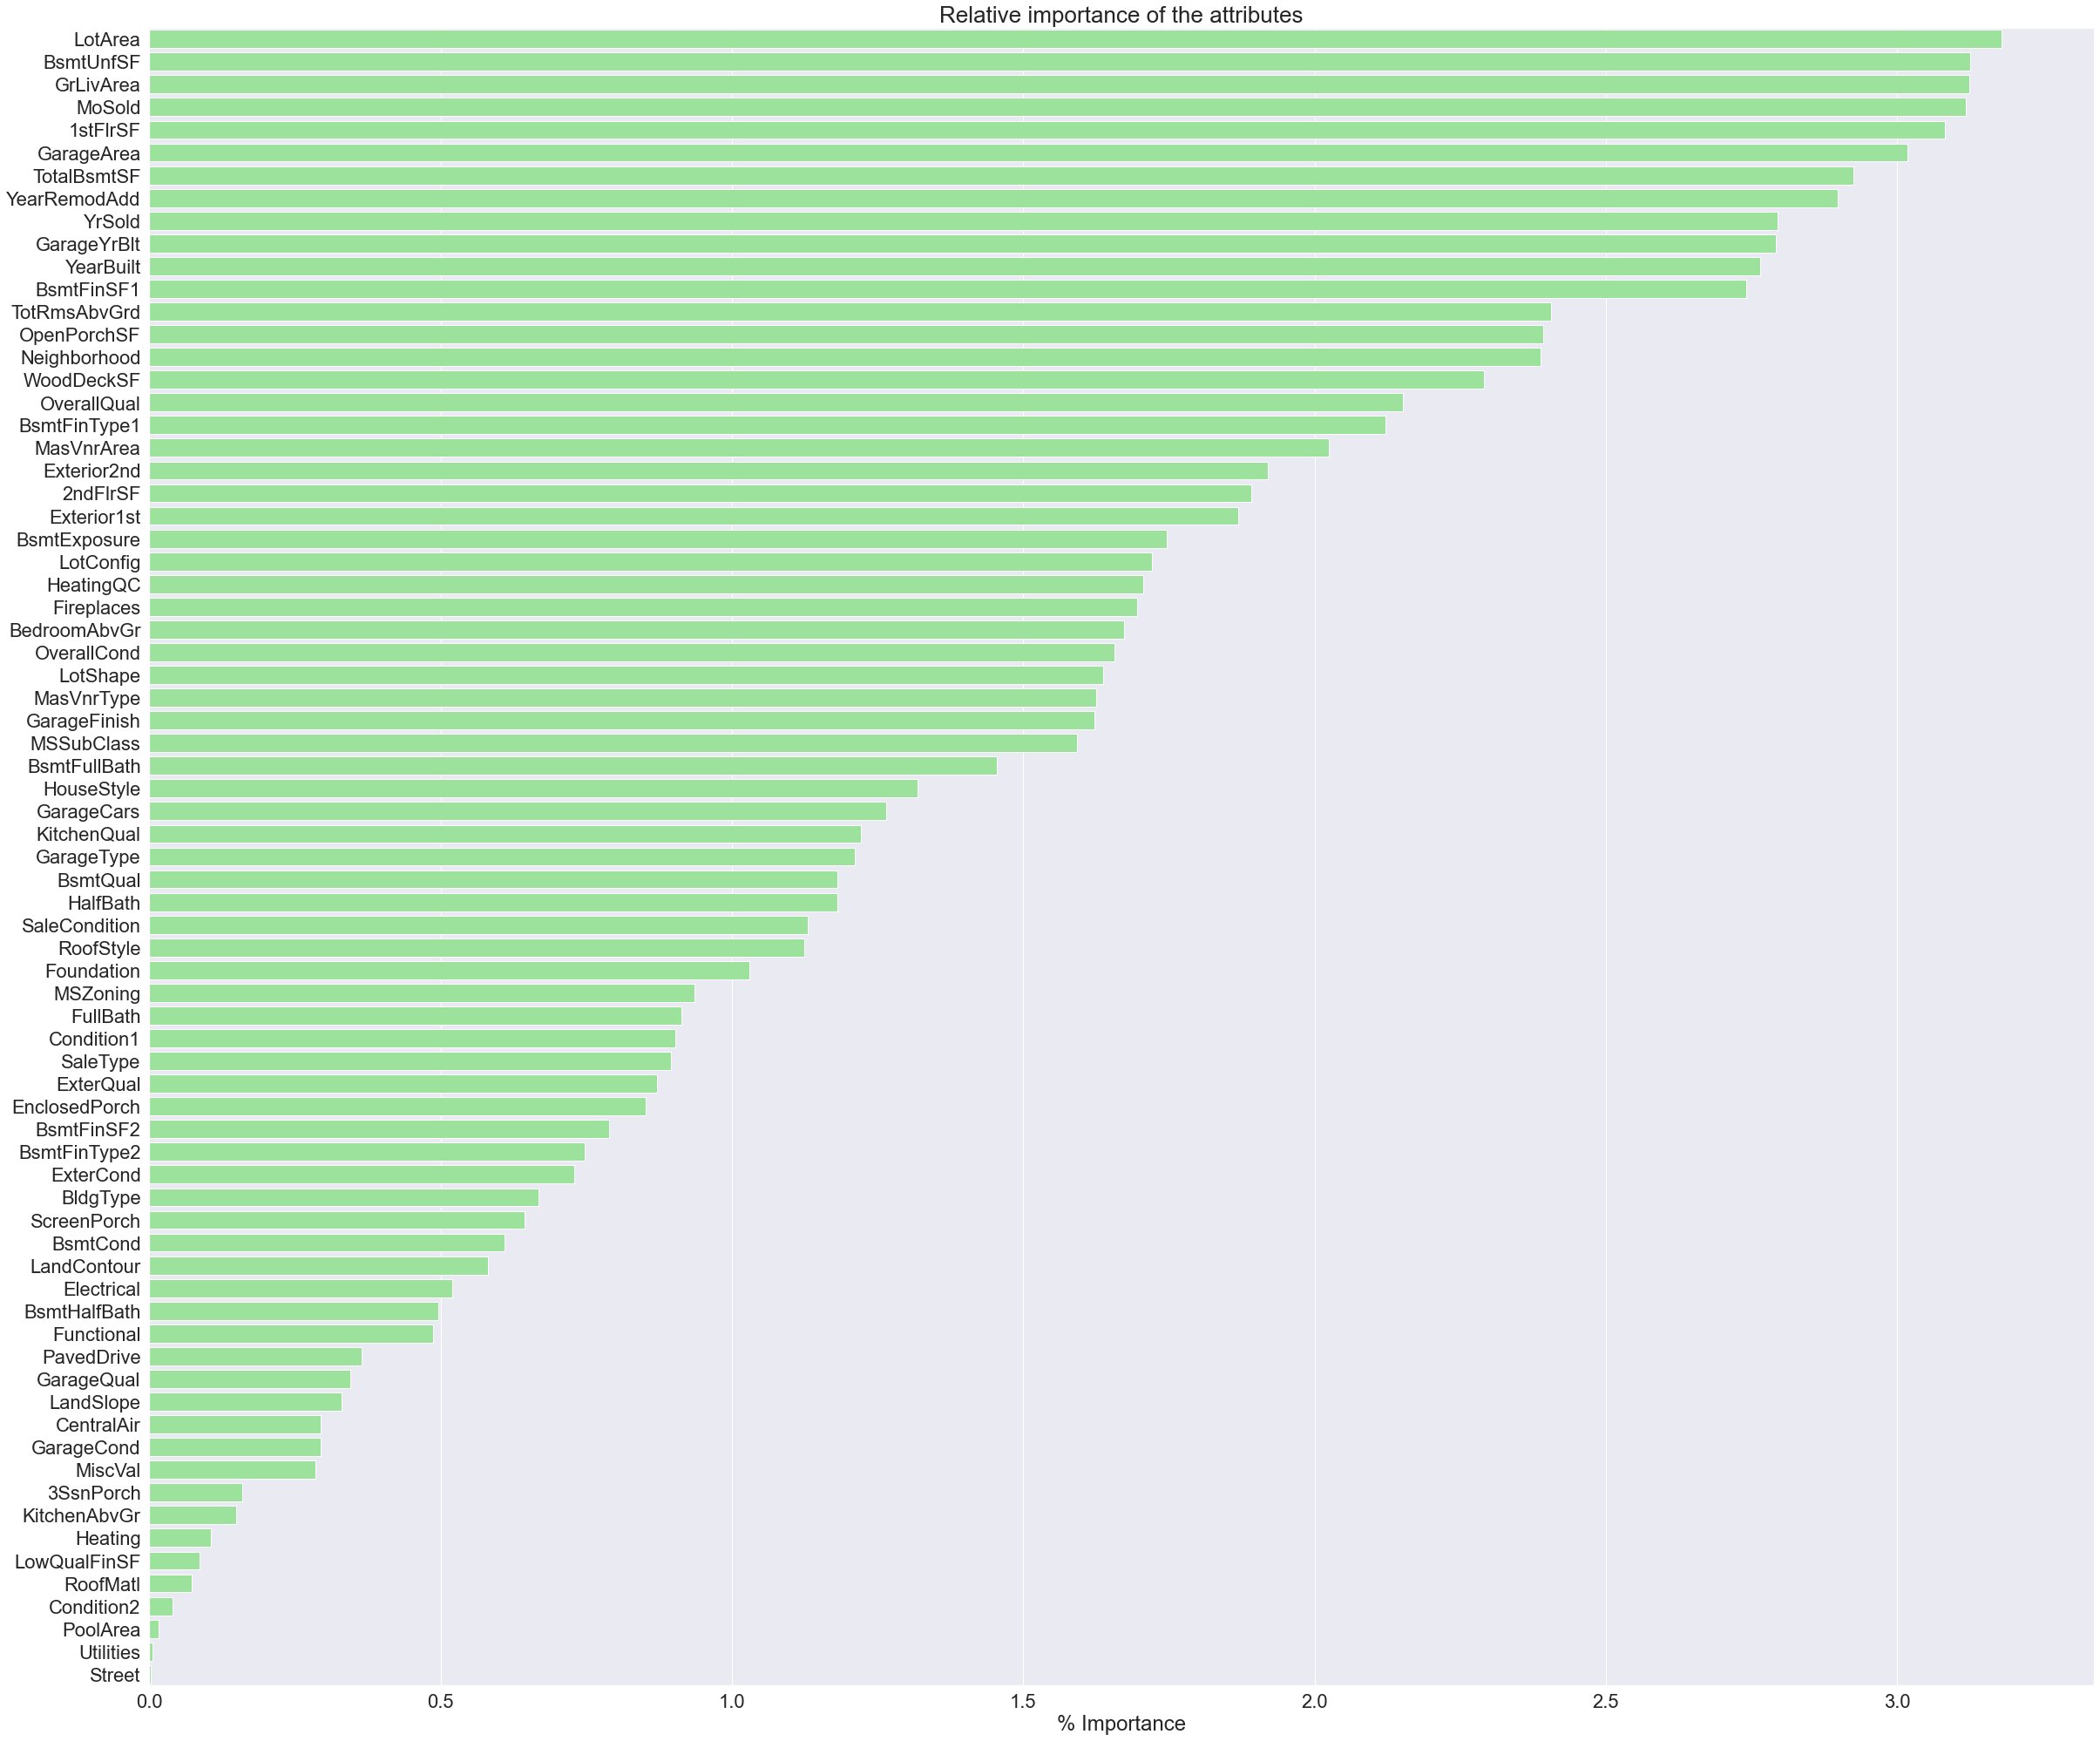

In [31]:
# Gráfico
plt.figure(figsize = (40,35))
sns.set(font_scale = 2)
b = sns.barplot(x = feat_importance_df["Relative_importance"], 
            y = feat_importance_df["Feature_name"], 
            orient = "h", 
            color="lightgreen")
plt.xlabel('% Importance')     
plt.ylabel('')            
plt.title("Relative importance of the attributes", fontdict = {'fontsize':26,'fontweight':500})

plt.show()

Depois eu quis entender quantas são as variáveis que apresentam uma importância relativa >= 1% (valor armazenado na variável "thresold_relative_importance"). E quanto da variação total dos dados essas variáveis representam (total de importância relativa acumulada: ~85%):

In [32]:
main_features = [index for index in range(len(features)) if features[index] >= thresold_relative_importance]
print(f'Total number of main features: {len(main_features)}.')
print(f'Total importance of the main features: {features[main_features].sum()}.')

Total number of main features: 42.
Total importance of the main features: 0.8580198812671819.


E agora sim, removendo os atributos menos importantes e deixando apenas os atributos principais na base de dados:

In [33]:
X_houses_scaler = pd.DataFrame(X_houses_scaler[:,main_features], columns=X_houses.columns[main_features])
print_dataset_shape(X_houses_scaler)

This dataset contains 1204 rows and 42 columns.


_______

#### Exportando os dados para usarmos no arquivo de construção dos modelos de machine learning:

In [34]:
with open("../data/house_prices.pkl", mode="wb") as f:
    pickle.dump([X_houses_scaler.values, y_houses], f)